In [115]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import torch.nn.init as init

In [116]:
#check for GPU availability
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define Functions

## 1) function to preprocess (1-hot encode) MONK data

In [117]:
def preprocess_monk(file_name):
    '''
    Load data from the Monk dataset and preprocess using one-hot encoding.

    Parameters:
    - file_name (str): The file name of the dataset.

    Returns:
    - x (torch.Tensor): Input data after one-hot encoding.
    - y (torch.Tensor): Target data.
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None,
                     names=['_','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'],
                     index_col=False)

    # Extract input features and target variable
    x1, x2, x3, x4, x5, x6, target = (np.array(df[feature]) for feature in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'target'])

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Reshape and transform x1 using one-hot encoding
    input_one_hot = encoder.fit_transform(x1.reshape(-1, 1))

    # Loop through the remaining input features and concatenate one-hot encoded values
    for x in [x2,x3,x4,x5,x6]:
        data =x.reshape(-1, 1)
        one_hot_encoded = encoder.fit_transform(data)
        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    # Convert to PyTorch tensors
    x = torch.tensor(input_one_hot, dtype=torch.float32)#.cuda()
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)#.cuda()

    return x, y

## Function to plot training curves

In [118]:
def plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies):
    '''
    Plot training and test curves for loss and accuracy.

    Parameters:
    - epoch (int): The number of epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - test_accuracies (list): List of test accuracies for each epoch.

    Returns:
    None
    '''
    plt.figure(figsize=(12, 4))

    # Loss plots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plots
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define the model

In [119]:
# Define the classifier

class MonkClassifier(nn.Module):
    def __init__(self, hidden_size, input_size=17, output_size=1, weight_init_constant=0.01):
        super(MonkClassifier, self).__init__()

        # Custom weight initialization function
        def init_weights(m):
            if type(m) == nn.Linear:
                if hasattr(m, 'weight') and m.weight is not None:
                    init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                    if m.bias is not None:
                        init.constant_(m.bias, 0)

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

        # Apply custom weight initialization to linear layers
        self.apply(init_weights)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

In [120]:
def training_model(x_train, y_train, x_test, y_test, hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs=1000, plot_curves=False):
    '''
    Train a Monk classifier model.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test (or Validation) input data.
    - y_test (torch.Tensor): Test (or Validation) target data.
    - hidden_size (int): Size of the hidden layer in the model.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - batch_size (int): Batch size for training and testing.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - num_epochs (int): Maximum number of training epochs (default: 1000).
    - plot_curves (bool): Whether to plot training curves (default: False).

    Returns:
    - epoch (int): Number of epochs completed.
    - train_loss (float): Final training loss.
    - test_loss (float): Final test (or validation) loss.
    - train_accuracy (float): Final training accuracy.
    - test_accuracy (float): Final test (or validation) accuracy.
    '''

    # Create an instance of the model
    model = MonkClassifier(hidden_size)
    #model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)

    if plot_curves:
        # Lists to store training and test losses for plotting
        train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    # parameters to stop at training convergence
    prev_loss = float('inf')
    patience_counter, patience = 0, 10

    for epoch in range(num_epochs):
        total_loss, total_accuracy = 0.0, 0.0
        # Mini-batch training

        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()   # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)   # Compute the loss
            loss.backward() # Backward pass
            optimizer.step()    # Update weights


            prev_loss = loss.item()
            # Accumulate the total loss for this epoch
            total_loss += loss.item()

            # Calculate training accuracy
            predicted_labels = torch.round(outputs)
            correct_predictions = (predicted_labels == labels).sum().item()
            total_samples = labels.size(0)
            total_accuracy += correct_predictions / total_samples

        # Print average training loss and accuracy for the epoch
        average_loss = total_loss / len(train_dataloader)
        average_accuracy = total_accuracy / len(train_dataloader)

        #print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, '
        #      f'Accuracy: {average_accuracy:.4f}')

        if plot_curves:
            train_losses.append(average_loss)
            train_accuracies.append(average_accuracy)

        # Evaluation on the test set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            total_test_loss, total_test_accuracy = 0.0, 0.0
            for test_inputs, test_labels in test_dataloader:
                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_labels)
                total_test_loss += test_loss.item()

                # Calculate test accuracy
                predicted_labels = torch.round(test_outputs)
                correct_predictions = (predicted_labels == test_labels).sum().item()
                total_samples = test_labels.size(0)
                total_test_accuracy += correct_predictions / total_samples

            average_test_loss = total_test_loss / len(test_dataloader)
            average_test_accuracy = total_test_accuracy / len(test_dataloader)

            #print(f'Test - Epoch [{epoch+1}/{num_epochs}], Loss: {average_test_loss:.4f},'
            #       f'Accuracy: {average_test_accuracy:.4f}')

            if plot_curves:
                test_accuracies.append(average_test_accuracy)
                test_losses.append(average_test_loss)

        # Check for convergence
        if abs(prev_loss - average_loss) < 1e-3:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break

        prev_loss = average_loss

    print(f'N. Epochs = {epoch+1} - Loss (train | test)= ({average_loss:.4} | {average_test_loss:.4}) - Accuracy (train | test) = ({average_accuracy} | {average_test_accuracy})')

    if plot_curves:
        plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies)

    return epoch+1, average_loss, average_test_loss, average_accuracy, average_test_accuracy

In [121]:
def perform_grid_search_kfold(hidden_sizes, learning_rates, momentums, batch_sizes, reg_coeffs, k_folds, x, y, plot_curves=False):
    '''
    Perform grid search with k-fold cross-validation for Monk classifier hyperparameters.

    Parameters:
    - hidden_sizes (list): List of hidden layer sizes to explore.
    - learning_rates (list): List of learning rates to explore.
    - momentums (list): List of momentum values to explore.
    - batch_sizes (list): List of batch sizes to explore.
    - reg_coeffs (list): List of regularization coefficients to explore.
    - k_folds (int): Number of folds for cross-validation.
    - x (torch.Tensor): Input data.
    - y (torch.Tensor): Target data.
    - plot_curves (bool): Whether to plot training curves for each hyperparameter combination (default: False).

    Returns:
    - best_hyperparams (list): List of best hyperparameters based on highest average validation accuracy.
    '''

    best_acc = 0
    best_hyperparams = []

    for hidden_size, learning_rate, momentum, bs, reg_coeff in product(hidden_sizes,learning_rates,momentums,batch_sizes, reg_coeffs):
        print(f'hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}')

        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and accuracies for each epoch
        train_losses, val_losses, train_acc, val_acc = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            max_epoch, average_loss, average_val_loss, average_accuracy, average_val_accuracy = training_model(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                hidden_size=hidden_size, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, plot_curves=plot_curves)

            train_losses.append(average_loss)
            val_losses.append(average_val_loss)
            train_acc.append(average_accuracy)
            val_acc.append(average_val_accuracy)

        print(f'Final Results: hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_acc = {np.mean(train_acc):.4} +- {np.std(train_acc):.4} | '
            f'val_acc = {np.mean(val_acc):.4} +- {np.std(val_acc):.4}')

        if np.mean(val_acc) >= best_acc:
            best_acc = np.mean(val_acc)
            best_hyperparams = [hidden_size, learning_rate, momentum, bs, reg_coeff]

    print(best_hyperparams)
    return best_hyperparams

# Monk 1

In [122]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([124, 17])
torch.Size([124, 1])
torch.Size([432, 17])
torch.Size([432, 1])


## Perform Model Selection

In [134]:
hidden_sizes = [5]
learning_rates = [0.1]
momentums = [0.8]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.2; alpha = 0.8; batch size = 4; lambda = 0
N. Epochs = 72 - Loss (train | test)= (0.00046 | 0.003076) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 46 - Loss (train | test)= (0.0006443 | 0.002467) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 1000 - Loss (train | test)= (0.03002 | 0.07155) - Accuracy (train | test) = (0.97 | 0.9285714285714286)
N. Epochs = 30 - Loss (train | test)= (0.0004521 | 0.002591) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 39 - Loss (train | test)= (0.001079 | 0.003429) - Accuracy (train | test) = (1.0 | 1.0)
Final Results: hidden_size=5; lr=0.2; alpha = 0.8; batch size = 4; lambda = 0 --> train_loss = 0.006531 +- 0.01175 | val_loss = 0.01662 +- 0.02747train_acc = 0.994 +- 0.012 | val_acc = 0.9857 +- 0.02857
[5, 0.2, 0.8, 4, 0]


N. Epochs = 44 - Loss (train | test)= (0.0004409 | 0.001118) - Accuracy (train | test) = (1.0 | 1.0)


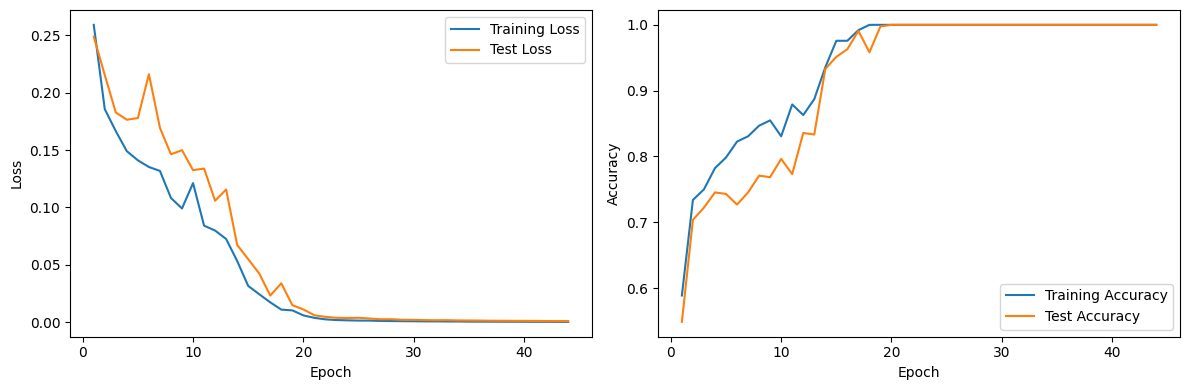

(44, 0.0004409105270995849, 0.001118450709725361, 1.0, 1.0)

In [135]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)